#### Imports

In [7]:
from optimizers import *
from functions import *
import numpy as np
import matplotlib.pyplot as plt

# A more complicated function

$$ N = 6, M = 10, F : \R^N \to \R^M$$

$$ F(x) = \begin{bmatrix}
    \sin(x_1) + \cos(2x_1) - 1 \\
    10\cos(-2x_2 + 1) + 3 \\
    2 \exp((x_3 + 10) / ||x||_2) \\
    \exp(\sin(\pi/2 + ||x||_2)) - 10 \\
    \left(\ln\left(3 + \left|\sum_{i=1}^{N} x_i\right|\right) - 1\right)^2 \\
    \cos(\exp(\sin^2(x_5))) \\
    5\left(\sin\left(\sqrt{|\sum_{i=1}^N x_i|} - 1\right)\right)^2 + 1\\
    \sqrt{|\cos(\exp(\sin(x_8)))|} \\
    ||x||_2^2 - 5 \\
    |\sum_{i=1}^N x_i| - 1
\end{bmatrix}$$

In [8]:
N = 6

F1 = compose(proj(N)(0), sin + compose(mul_const(2), cos)) - constM(N)(1)
F2 = compose(proj(N)(1), mul_const(-2) + const1(1), const1(10) * cos) + constM(N)(3)
F3 = compose((proj(N)(2) + constM(N)(10)) / norm_sqr(N), 2 * exp)
F4 = compose(norm_sqr(N) + constM(N)(np.pi / 2), sin, exp) - constM(N)(10)
F5 = compose(compose(sum_(N), abs) + constM(N)(3), log - const1(1), square)
F6 = compose(proj(N)(4), sin, square, exp, cos)
F7 = compose(sum_(N), sqrt - const1(1), sin, const1(5) * square) + constM(N)(1)
F8 = compose(proj(N)(5), sin, exp, cos, const1(2) - const1(5) * sqrt)
F9 = norm_sqr(N) - constM(N)(5)
F10 = compose(sum_(N), abs) - constM(N)(1)
F = stack(F1, F2, F3, F4, F5, F6, F7, F8, F9, F10)

# Performance tests

Running Newton


Newton: 100%|██████████| 500/500 [00:02<00:00, 180.50it/s]


Running Gauss-Newton


Gauss-Newton: 100%|██████████| 500/500 [00:00<00:00, 718.62it/s]


Running Gradient descent


Gradient descent: 100%|██████████| 500/500 [00:00<00:00, 815.92it/s]


Running Levenberg-Marquardt (const)


Levenberg-Marquardt: 100%|██████████| 500/500 [00:00<00:00, 601.15it/s]


Running Levenberg-Marquardt (modifying)


Levenberg-Marquardt: 100%|██████████| 500/500 [00:03<00:00, 156.44it/s]


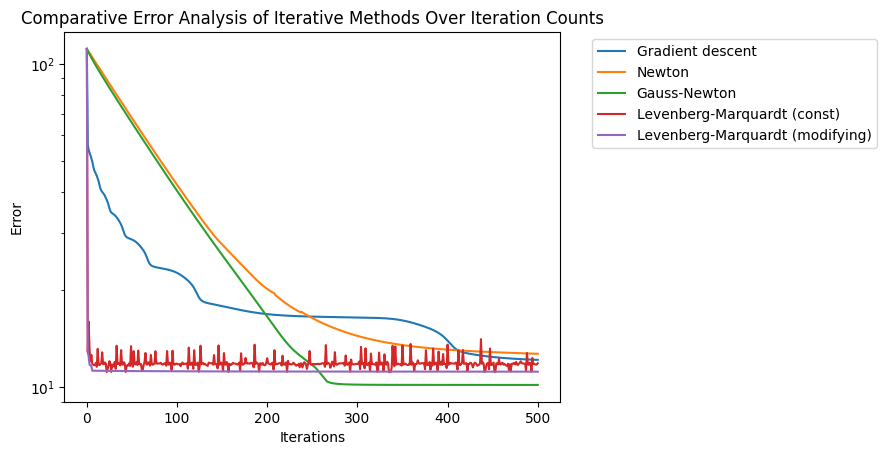

In [9]:
max_iter = 500
p0 = np.random.randn(N)
alpha_gd = 1e-4
alpha_gn = 1e-2
lambda0 = 1.
lambda_change = 1.1
step_max_iter = 10
step_tol = 1e-6

NEWTON = "Newton"
GAUSS_NEWTON = "Gauss-Newton"
GRADIENT_DESCENT = "Gradient descent"
LEVENBERG_MARQUARDT_CONST_PARAM = "Levenberg-Marquardt (const)"
LEVENBERG_MARQUARDT_MODIFYING_PARAM = "Levenberg-Marquardt (modifying)"
optimizer_names = [
    GRADIENT_DESCENT,
    NEWTON,
    GAUSS_NEWTON,
    LEVENBERG_MARQUARDT_CONST_PARAM,
    LEVENBERG_MARQUARDT_MODIFYING_PARAM,
]

errors = {name: [] for name in optimizer_names}
points = {name: [] for name in optimizer_names}

optimizer_functions = {
    NEWTON: lambda points, errs: newton(R=F, p0=p0, max_iter=max_iter, alpha=alpha_gn, points=points, errs=errs),
    GAUSS_NEWTON: lambda points, errs: gauss_newton(R=F, p0=p0, alpha=alpha_gn, max_iter=max_iter, points=points, errs=errs),
    GRADIENT_DESCENT: lambda points, errs: gradient_descent(R=F, p0=p0, alpha=alpha_gd, max_iter=max_iter, points=points, errs=errs),
    LEVENBERG_MARQUARDT_CONST_PARAM: lambda points, errs: (
        LevenbergMarquardt(R=F, lambda_param_fun=LevenbergMarquardt.LambdaParamConstant(lambda0=lambda0))
        .optimize(p0, max_iter, step_type="cgnr", step_max_iter=step_max_iter, step_tol=step_tol, points=points, errs=errs)
    ),
    LEVENBERG_MARQUARDT_MODIFYING_PARAM: lambda points, errs: (
        LevenbergMarquardt(R=F, lambda_param_fun=LevenbergMarquardt.LambdaParamDefaultModifier(lambda0=lambda0, lambda_change=lambda_change))
        .optimize(p0, max_iter, step_type="cgnr", step_max_iter=step_max_iter, step_tol=step_tol, points=points, errs=errs)
    ),
}

for name, optimizer in optimizer_functions.items():
    print("Running " + name)
    optimizer(points=points[name], errs=errors[name])

iters = np.arange(0, max_iter + 1)
for label, err in errors.items():
    try:
        plt.plot(iters, err, label=label)
    except:
        print("error in plotting for " + label)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Iterations")
plt.ylabel("Error")
plt.yscale("log")
plt.title("Comparative Error Analysis of Iterative Methods Over Iteration Counts")
plt.show()